In [23]:
!pip install transformers
!pip install datasets
!pip install umap-learn
!pip install accelerate -U

0 - OFFENSIVE <br>
1 - NOT OFFENSIVE

In [31]:
from datasets import load_dataset, Dataset

In [32]:
dataset_albanian = load_dataset('strombergnlp/shaj')['train'].train_test_split(train_size=0.8,
                                                                      seed=42)

print(dataset_albanian)

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'subtask_a', 'subtask_b', 'subtask_c'],
        num_rows: 9499
    })
    test: Dataset({
        features: ['id', 'text', 'subtask_a', 'subtask_b', 'subtask_c'],
        num_rows: 2375
    })
})


In [33]:
import pandas as pd

#removal of very long sequences within the text
df_train = dataset_albanian['train'].to_pandas()
df_test = dataset_albanian['test'].to_pandas()

df = pd.concat([df_train, df_test])

df['Text length'] = df['text'].apply(lambda x: len(x))
df_updated = df.sort_values(by = "Text length", ascending=False).reset_index().iloc[32:, :]

In [181]:
#removal of emojis
'''import re
def remove_emojis(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)

df_updated['text'] = df_updated['text'].apply(lambda x: remove_emojis(x))'''

'import re\n\ndef remove_emojis(text):\n  emoji_pattern = re.compile("["\n                           u"😀-🙏"  # emoticons\n                           u"🌀-🗿"  # symbols & pictographs\n                           u"🚀-\U0001f6ff"  # transport & map symbols\n                           u"\U0001f1e0-🇿"  # flags (iOS)\n                           u"✂-➰"\n                           u"Ⓜ-🉑"\n                           "]+", flags=re.UNICODE)\n  return emoji_pattern.sub(r\'\', text)\n\ndf_updated[\'text\'] = df_updated[\'text\'].apply(lambda x: remove_emojis(x))'

Since our model's max number of tokens it can take is 512, it would be beneficial to drop the rows with 512+ tokens.

In [34]:
from transformers import AutoTokenizer

#checkpoint = 'bert-base-multilingual-cased'

checkpoint = 'distilbert-base-multilingual-cased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)


In [44]:
#Convert from pandas dataframe to DatasetDict

dataset = Dataset.from_dict(df_updated)
dataset_albanian = dataset.train_test_split(train_size=0.8,
                                            seed=42)

In [45]:
#printing results
dataset_albanian

DatasetDict({
    train: Dataset({
        features: ['index', 'id', 'text', 'subtask_a', 'subtask_b', 'subtask_c', 'Text length'],
        num_rows: 9473
    })
    test: Dataset({
        features: ['index', 'id', 'text', 'subtask_a', 'subtask_b', 'subtask_c', 'Text length'],
        num_rows: 2369
    })
})

In [46]:
#Applying some subword tokenization
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [47]:
encoded_dataset_albanian = dataset_albanian.map(tokenize, batched=True, batch_size=None) #+input_ids , +attention_mask

Map:   0%|          | 0/9473 [00:00<?, ? examples/s]

Map:   0%|          | 0/2369 [00:00<?, ? examples/s]

##Feature Extraction Style

In [48]:
from transformers import AutoModel
import torch

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(checkpoint).to(device)

In [50]:
#clear cache
torch.cuda.empty_cache()

In [125]:
#print({k:v for k,v in encoded_dataset_albanian.items()})

{'train': Dataset({
    features: ['index', 'id', 'text', 'subtask_a', 'subtask_b', 'subtask_c', 'Text length', 'input_ids', 'attention_mask'],
    num_rows: 9473
}), 'test': Dataset({
    features: ['index', 'id', 'text', 'subtask_a', 'subtask_b', 'subtask_c', 'Text length', 'input_ids', 'attention_mask'],
    num_rows: 2369
})}


In [51]:
#hidden states representing embeddings
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [52]:
encoded_dataset_albanian.set_format("torch")
encoded_dataset_albanian = encoded_dataset_albanian.rename_column("subtask_a" ,"labels")
encoded_dataset_albanian = encoded_dataset_albanian.remove_columns(['index','id','subtask_b','subtask_c','Text length'])

#encoded_dataset_albanian['train'][0]['input_ids'].size() #very very long sequences? Probably the model is not so powerful to handle it????

In [53]:
hidden_dataset = encoded_dataset_albanian.map(extract_hidden_states, #What can we do in this case? It would be better if we could apply feature extraction
                                              batched=True)

Map:   0%|          | 0/9473 [00:00<?, ? examples/s]

Map:   0%|          | 0/2369 [00:00<?, ? examples/s]

In [54]:
'''

Applying feature extraction technique to make predictions.
Hidden state vectors will serve as the features and the label_ids as the target variable.


'''

print(hidden_dataset['train']['hidden_state'][0].size()) #it captures all the values for each [CLS] token, it makes sense, since this token
#is responsible for the classification (higher significance or representation)

torch.Size([768])


##Feature Extraction

In [56]:
#Create split sets
import numpy as np

X_train = np.array(hidden_dataset['train']['hidden_state'])
X_test  = np.array(hidden_dataset['test']['hidden_state'])
y_train = np.array(hidden_dataset['train']['labels'])
y_test  = np.array(hidden_dataset['test']['labels'])

X_train.shape, X_test.shape

((9473, 768), (2369, 768))

In [57]:
#Compressing hidden states, from 768 to 2
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


#applying min-max scaler for normalization
X_scaled = MinMaxScaler().fit_transform(X_train)


#create a pandas dataframe with mapper values
mapper = UMAP(n_components=2,
              metric="cosine").fit(X_scaled)
df_embeddings = pd.DataFrame(mapper.embedding_, #embeddings compressed
                             columns=["X1","X2"])


df_embeddings['labels'] = y_train

Let's check the balance of the data, and if the data will be imbalanced, let's apply some resampling in order to balance the dataset. When we will do predictions, it's good to see how the model is doing with the balanced but also imbalanced dataset (if exists)

<Axes: >

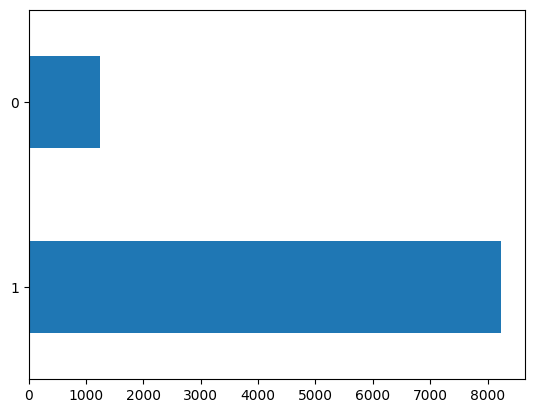

In [58]:
df_embeddings['labels'].value_counts().plot(kind="barh")

We can see that our dataset is really imbalanced. Let's try to balance it.

<Axes: >

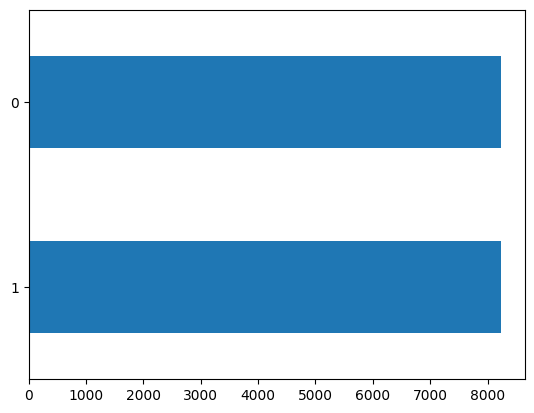

In [59]:
#balancing the dataset
from imblearn.over_sampling import SMOTE

# Initialize the SMOTE object and create X_train and y_train for embeddings
smote = SMOTE(random_state=42)
X_train_embeddings = df_embeddings[['X1','X2']]
y_train_embeddings = df_embeddings['labels']

# Resample the training set
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_embeddings, y_train_embeddings)

y_train_resampled.value_counts().plot(kind="barh") #we can see that our dataset is now balanced

In [60]:
#Lets test everything with several classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, log_loss, accuracy_score

models = {'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(max_depth=5),
    'DecisionTreeClassifier': DecisionTreeClassifier(max_depth=5, random_state=42)}


def loss(y_true, y_pred, retu=False):
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    loss = log_loss(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    if retu:
        return pre, rec, f1, loss, acc
    else:
        print('  pre: %.3f\n  rec: %.3f\n  f1: %.3f\n  loss: %.3f\n  acc: %.3f' % (pre, rec, f1, loss, acc))



def train_eval_train(models, X, y):
    for name, model in models.items():
        print(name,':')
        model.fit(X, y)
        loss(y, model.predict(X))
        print('-'*30)


print(train_eval_train(models, X_train_resampled, y_train_resampled))

LogisticRegression :
  pre: 0.594
  rec: 0.536
  f1: 0.564
  loss: 14.951
  acc: 0.585
------------------------------
RandomForestClassifier :
  pre: 0.714
  rec: 0.546
  f1: 0.619
  loss: 12.112
  acc: 0.664
------------------------------
DecisionTreeClassifier :
  pre: 0.647
  rec: 0.657
  f1: 0.652
  loss: 12.654
  acc: 0.649
------------------------------
None


We can see that the results are not so good, probably acceptable in RandomForest and DecisionTree, but still the value of loss is very high. Let's proceed with fine tuning method, to update our pretrained model's weights in the Text Classification task.

##Full Fine Tuning

In [61]:
from transformers import AutoModelForSequenceClassification

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [62]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

#The function to compute f1 score and accuracy
def compute_metrics(preds):

  labels = preds.label_ids
  predictions = preds.predictions.argmax(-1)

  return {"F1-Score: ": f1_score(labels, predictions),
          "Accuracy Score: ": accuracy_score(labels,predictions)}


In [63]:
from huggingface_hub import notebook_login

notebook_login()

In [64]:
#Initializing hyperparameters that will get updated
from transformers import TrainingArguments, Trainer

batch_size = 64
logging_steps = len(encoded_dataset_albanian["train"]) // batch_size
model_name = f"{checkpoint}-finetuned-sentiment-albanian"

training_args = TrainingArguments(output_dir = model_name,
                                  num_train_epochs = 3,
                                  learning_rate = 2e-5,
                                  per_device_eval_batch_size=batch_size,
                                  per_device_train_batch_size=batch_size,
                                  weight_decay = 0.1,
                                  evaluation_strategy = "epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")

In [204]:
#print(encoded_dataset_albanian)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 9473
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 2369
    })
})


In [65]:
trainer = Trainer(model,
                  args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=encoded_dataset_albanian['train'],
                  eval_dataset=encoded_dataset_albanian['test'],
                  tokenizer=tokenizer)

trainer.train()

Cloning https://huggingface.co/Gerti/distilbert-base-multilingual-cased-finetuned-sentiment-albanian into local empty directory.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1-score:,Accuracy score:
1,0.369800,0.342363,0.929024,0.867455
2,0.299500,0.317440,0.936199,0.882229
3,0.251000,0.312611,0.939281,0.890249


TrainOutput(global_step=447, training_loss=0.3057452152906115, metrics={'train_runtime': 494.0789, 'train_samples_per_second': 57.519, 'train_steps_per_second': 0.905, 'total_flos': 1419074342703396.0, 'train_loss': 0.3057452152906115, 'epoch': 3.0})

##Predictions

In [66]:
import numpy as np

preds = trainer.predict(encoded_dataset_albanian['test'])

#predictions
y_pred = np.argmax(preds.predictions,
                   axis=-1)

#true labels
y_true = preds.label_ids

#metrics
results_1 = preds.metrics

results_1

{'test_loss': 0.31261056661605835,
 'test_F1-Score: ': 0.9392807099486222,
 'test_Accuracy Score: ': 0.8902490502321655,
 'test_runtime': 12.232,
 'test_samples_per_second': 193.673,
 'test_steps_per_second': 3.107}

We will plot now a confusion matrix, in order to see how much predictions impact labels and vice versa.

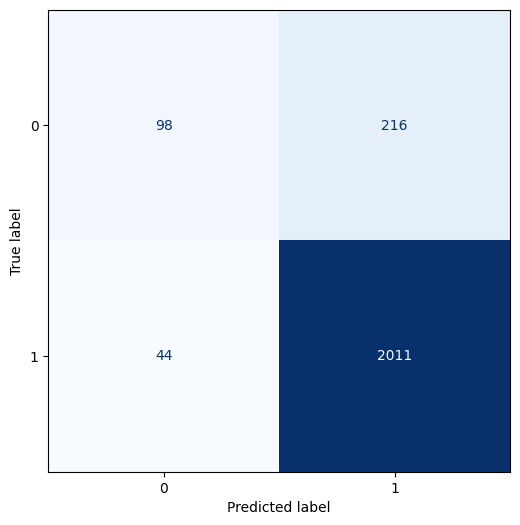

In [67]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred):

  cm = confusion_matrix(y_true, y_pred)
  fig,  ax = plt.subplots(figsize=(6,6))

  display = ConfusionMatrixDisplay(confusion_matrix = cm
                                   )

  display.plot(cmap="Blues",
            ax=ax,
            colorbar=False)

plot_confusion_matrix(y_true, y_pred)

Until now we worked with the imbalanced dataset in the Fine Tuning part. We can take another approach now, try to balance our dataset. We can do that by applying <b>Class Weights Optimization</b>. What this approach intents to do, is introducing some weights that will multiply each one of the classes by an amount defined in the data. We might assign higher weights to more rare classes and a lower weight to most common classes. <br>

The code is taken by a project I have worked earlier with the emotion dataset:

[Link](https://github.com/GSana2812/NLP/blob/main/Fine_Tuning_using_Trainer_API.ipynb)

In [68]:
encoded_dataset_albanian['train']

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 9473
})

In [69]:
import numpy as np
import torch

encoded_dataset_df = encoded_dataset_albanian['train'].to_pandas()

class_weights = np.array(1 - encoded_dataset_df['labels'].value_counts(normalize=True).sort_index())
class_weights #huge imbalance


#All the weights should be as torch tensors, since the Trainer API is based on torch tensors
class_weights_tensors = torch.from_numpy(class_weights).float().to("cuda")

In [70]:
#Build the Weighted Loss Function
class WeightedLoss(Trainer):

  def compute_loss(self, model, inputs, return_outputs=False):

    preds = model(**inputs).logits
    labels = inputs.get("labels")

    loss_func = torch.nn.CrossEntropyLoss(class_weights_tensors)
    loss = loss_func(preds, labels)

    return (loss, model(**inputs)) if return_outputs else loss

In [71]:
#Initializing the WeightedTrainer
weighted_trainer = WeightedLoss(model,
                                   training_args,
                                   train_dataset = encoded_dataset_albanian['train'],
                                   eval_dataset = encoded_dataset_albanian['test'],
                                   tokenizer = tokenizer,
                                   compute_metrics = compute_metrics,
                                   )


weighted_trainer.train()

/content/distilbert-base-multilingual-cased-finetuned-sentiment-albanian is already a clone of https://huggingface.co/Gerti/distilbert-base-multilingual-cased-finetuned-sentiment-albanian. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1-score:,Accuracy score:
1,0.386300,0.636014,0.909182,0.846771
2,0.244900,0.829649,0.932949,0.882229
3,0.218800,0.792611,0.927374,0.873786


TrainOutput(global_step=447, training_loss=0.28252249829454446, metrics={'train_runtime': 531.6168, 'train_samples_per_second': 53.458, 'train_steps_per_second': 0.841, 'total_flos': 1419074342703396.0, 'train_loss': 0.28252249829454446, 'epoch': 3.0})

In [72]:
wpreds = trainer.predict(encoded_dataset_albanian['test'])

#predictions
y_pred = np.argmax(preds.predictions,
                   axis=-1)

#true labels
y_true = preds.label_ids

#metrics
results_2 = preds.metrics

results_2 #big errors in some data, having high loss and high accuracy

{'test_loss': 0.31261056661605835,
 'test_F1-Score: ': 0.9392807099486222,
 'test_Accuracy Score: ': 0.8902490502321655,
 'test_runtime': 12.232,
 'test_samples_per_second': 193.673,
 'test_steps_per_second': 3.107}

Eventhough we applied balance between classes, we can see that the performance of data when imbalanced is actually quite better than when balanced.

##Error Analysis

We may think, that is enough, fine tuning the model and calculating the predictions, but it is not over. It would be good to analyze the model's performance based on the loss's perspective. We will create a new column called loss with also the predicted labels, and pass the data to a dataframe for further analysis in the test data.

In [81]:
import torch

from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):

# Place all input tensors on the same device as the model
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  with torch.no_grad():
    output = model(**inputs)
    pred_label = torch.argmax(output.logits, dim=-1)
    loss = cross_entropy(output.logits, batch["labels"].to(device),reduction="none")
  return {"loss": loss, "predicted_label": pred_label}

In [82]:
#applying the function to the dataset
encoded_dataset_albanian['test'] = encoded_dataset_albanian['test'].map(forward_pass_with_label,
                                                                        batched=True,
                                                                        batch_size=8)

Map:   0%|          | 0/2369 [00:00<?, ? examples/s]

In [83]:
#Updated dataset
encoded_dataset_albanian['test']

Dataset({
    features: ['text', 'labels', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2369
})

In [85]:
#getting df dataset
dataset_df = encoded_dataset_albanian['test'].to_pandas()

In [88]:
dataset_df.sort_values(by="loss", ascending=True).head(10)

,text,labels,input_ids,attention_mask,loss,predicted_label
800,Ikni mor ju qr se na shpifet Po qa dreqin te h...,0,"[101, 74122, 10342, 24984, 23005, 185, 10129, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.005833,0
1987,I qr na lat pa hanger buk me kto budalliqe,0,"[101, 146, 185, 10129, 10132, 12764, 10931, 60...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.005939,0
1456,Po dhe ti do ta hash gomarin e ngordhur vec se...,0,"[101, 11255, 11034, 14382, 10149, 11057, 10393...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.005955,0
587,"Tkesh ta hash ti naj thik bythve, qe mos t ece...",0,"[101, 157, 21885, 10237, 11057, 10393, 10237, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.006154,0
2225,Futi nbyth,0,"[101, 17056, 10325, 182, 11530, 11143, 102, 0,...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.006155,0
1336,Futi nbyth,0,"[101, 17056, 10325, 182, 11530, 11143, 102, 0,...","[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.006155,0
2250,Po fiks Allahu leshit ja heq ik ore se lat nam...,0,"[101, 11255, 19936, 10107, 22734, 10138, 10152...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.006163,0
399,Cfar ftyr derre ftyra si byth bytha si ftyra. ...,0,"[101, 140, 29731, 13786, 20728, 10118, 10246, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.006291,0
2020,Ore ti qenke kokra boles spaske pun tje ter ti,0,"[101, 19372, 10112, 14382, 50340, 53770, 11252...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.006391,0
1979,Po ti qenke me per te q.. rropt nga te gjithe...,0,"[101, 11255, 14382, 50340, 53770, 10911, 10178...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",0.006438,0


In [89]:
dataset_df.sort_values(by="loss", ascending=False).head(10)

,text,labels,input_ids,attention_mask,loss,predicted_label
932,"Adriano köln ...a ke qen naiher m,zall t.kirit",1,"[101, 53225, 179, 28565, 10115, 119, 119, 119,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.981124,0
983,Qenka bere tap I gjori qe te mos degjoj me bud...,1,"[101, 154, 10136, 10371, 15147, 66956, 146, 17...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.973804,0
1812,Beje byrek o mik del nice,1,"[101, 14321, 10381, 10155, 18113, 183, 12132, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...",4.739979,0
1312,Kete e besojn te gjth se e kam pae syt e mi ku...,1,"[101, 47124, 10216, 173, 10347, 11669, 19998, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.723295,0
154,Po pse skalon hiç ai për karroc à qafir à,1,"[101, 11255, 97764, 10112, 17183, 10263, 11019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.706894,0
2188,Me qe ju dhimset kaq shum I jepni ju se si duk...,1,"[101, 11589, 50340, 23005, 172, 31362, 14488, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.658856,0
2320,Ktu ja keni fut pordhes kot ....Gjeni na nje m...,1,"[101, 148, 10991, 10201, 67680, 10116, 11871, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.652796,0
64,"Ja thote qe ne femrat dime te parkojme,edhe na...",1,"[101, 28248, 77586, 24831, 50340, 10554, 20585...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.638788,0
543,Edhe themi per pakistanezet dhe kinezet shqipt...,0,"[101, 13114, 11643, 11345, 10116, 10178, 17284...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4.484873,1
418,Haj se ato ke porosit o magjar,1,"[101, 13740, 10418, 10126, 48388, 11163, 10183...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...",4.456048,0


It seems that the model has done a good job in most of the predictions. It seems that the highest values of loss, is performed in the majority class of the dataset(with label = 1). This probably comes by the fact that the data is imbalanced, with more than 70% of values being labeled as 1 or <b>not offend</b>.

##Saving and Sharing the model

In [94]:
from transformers import pipeline

trainer.push_to_hub(commit_message="Training completed!")

model_id = "Gerti/distilbert-base-multilingual-cased-finetuned-sentiment-albanian"
classifier = pipeline("text-classification", model=model_id)

Upload file pytorch_model.bin:   0%|          | 1.00/516M [00:00<?, ?B/s]

Upload file runs/Jul29_16-17-52_5a629b973334/events.out.tfevents.1690647480.5a629b973334.516.0:   0%|         …

Upload file runs/Jul29_16-17-52_5a629b973334/events.out.tfevents.1690648012.5a629b973334.516.1:   0%|         …

Upload file training_args.bin:   0%|          | 1.00/3.93k [00:00<?, ?B/s]

To https://huggingface.co/Gerti/distilbert-base-multilingual-cased-finetuned-sentiment-albanian
   9911fef..d7ad690  main -> main

   9911fef..d7ad690  main -> main

To https://huggingface.co/Gerti/distilbert-base-multilingual-cased-finetuned-sentiment-albanian
   d7ad690..36f3290  main -> main

   d7ad690..36f3290  main -> main



In [95]:
predictions = classifier("Kenaqesi per mua qe ju takoj")
print(predictions)

[{'label': 'LABEL_1', 'score': 0.9871147871017456}]


In [96]:
predictions = classifier("Ik se te qiva ropt")
print(predictions)

[{'label': 'LABEL_0', 'score': 0.9930920600891113}]
